# Floresta Aleatória

Este `notebook` tem por finalidade introduzir brevemente e aplicar o modelo Floresta Aleatória para a previsão de target categórico.

O modelo de floresta aleatória baseia-se no modelo de árvore de decisão visando equilibrar o alto viés e baixa variância desse. Para saber mais sobre árvores de decisão, recomendam-se as referências [1], para uma introdução teórica e [2] para aplicação computacional. De maneira breve, a floresta aleatória treina $n$ árvores de decisão, cada uma com uma amostra do conjunto de dados, prevê o resultado em cada uma delas e então tira a média ou a moda - a depender do target - e aponta como previsão final [3]. Como o dataset que estamos utilizando possui `target` categórico, para este problema a floresta aleatória será classificadora, o que significa que utilizará a moda das previsões fornecidas por seu comitê de árvores.

In [1]:
#Todos os módulos e funções importados para o funcionamento do presente notebook
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from optuna import create_study
from sklearn.preprocessing import LabelEncoder

## Importando o `dataframe`

O dataframe que iremos utilizar será aquele já tratado e dividido previamente no notebook `Tratamento_geral`.

In [2]:
features_treino = pd.read_csv('Features para treino.csv', index_col='Unnamed: 0', sep=',' )
features_teste = pd.read_csv('Features para teste.csv', index_col='Unnamed: 0', sep=',' )
target_treino = pd.read_csv('Target para treino.csv', index_col='Unnamed: 0', sep=',' ).to_numpy().reshape(-1)
target_teste = pd.read_csv('Target para teste.csv', index_col='Unnamed: 0', sep=',' )

## Seleção de atributos com `RandomForestClassifier`

A seleção de atributos foi proposta utilizando a função `SequentialFeatureSelector` com seus hiperparâmetros padrão, e o modelo `RandomForestClassifier`como algoritmo para escolha, também com hiperparâmetros padrão pelo `scikit-learn`. Entretanto, notou-se uma queda no desempenho do modelo de previsão após a implementação da seleção de atributos, e essa **não foi utilizada**. Por razões informativas, abaixo seguem os hiperparâmetros utilizados para cada item.

`RandomForestClassifier`: como rdf_class
-  n_estimators=100, 
- criterion='gini', 
- min_samples_split=2, 
- min_samples_leaf=1,
- max_features='sqrt',
- min_impurity_decrease=0.0, 
- bootstrap=True, 
- random_state=57;

`SequentialFeatureSelector`:
- rdf_class,
- n_features_to_select="auto",
- direction="backward",
- scoring="f1".

O número de jobs foi omitido, em razão de ser uma decisão daquele que irá rodar o código. "random_state" corresponde à semente aleatória escolhida durante os testes, para garantir reprodutibilidade.



## Otimização de hiperparâmetros 

A otimização de hiperparâmetros será feita através do `optuna` com o dataframe de treino.

As funções aqui utilizadas para otimização de hiperparâmetros foram disponibilizadas segundo a referência [4].

In [3]:
def instancia_modelo(trial):
    """Cria uma instância do modelo.

    Argumentos:
      trial: objeto tipo Trial do optuna.

    Returno:
      Uma instância do modelo desejado.

    """
    
    parametros = {
        "n_estimators": trial.suggest_int("num_arvores", 100, 300),
        "criterion": trial.suggest_categorical("critério", ["gini", "entropy", "log_loss"]),
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 15),
        "max_features": trial.suggest_float("num_max_atributos", 0, 1),
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": RANDOM_SEED,
    }

    modelo = RandomForestClassifier(**parametros)
    
    return modelo

Note que o número de árvores, mínimo de amostras para split e mínimo de exemplos por folha foram escolhidos após alguns testes apenas com a otimização de hiperparâmetros.

In [4]:
def funcao_objetivo(trial, features_treino, y, num_folds):
    """Função objetivo do optuna"""

    modelo = instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        features_treino,
        y,
        scoring='f1',
        cv=num_folds,
    )

    return metricas.mean()

In [9]:
NOME_DO_ESTUDO = "random_forest_class_ABA"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,)

[I 2025-11-03 21:25:12,580] A new study created in RDB with name: random_forest_class_ABA_final


Também faremos conjuntos de hiperparâmetros que julgamos relevantes para serem testados pelo `optuna` utilizando a função `enqueue_trial`. Aqui, esses hiperparâmetros serão os critérios de qualidade do split "gini", "entropy" e "log_loss". Os outros hiperparâmetros serão os padrão do `scikit-learn` para a floresta aleatória classificadora.

In [10]:
RANDOM_SEED = 57

objeto_de_estudo.enqueue_trial(
    {
        "n_estimators": 200,
        "criterion": "gini",
        "min_samples_split": 9,
        "min_samples_leaf": 8,
        "max_features": "sqrt",
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": RANDOM_SEED,
    }
)

objeto_de_estudo.enqueue_trial(
    {
        "n_estimators": 200,
        "criterion": "entropy",
        "min_samples_split": 9,
        "min_samples_leaf": 8,
        "max_features": "sqrt",
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": RANDOM_SEED,
    }
)

objeto_de_estudo.enqueue_trial(
    {
        "n_estimators": 200,
        "criterion": "log_loss",
        "min_samples_split": 9,
        "min_samples_leaf": 8,
        "max_features": "sqrt",
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": RANDOM_SEED,
    }
)

O número de folds para a validação cruzada durante a otimização será de igual à 5, sendo feitas 100 tnetativas de otimização de hiperparâmetros.

In [11]:
le=LabelEncoder()
y = le.fit_transform(y=target_treino)

N_FOLDS = 5
N_TENTATIVAS = 100

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, features_treino, y, N_FOLDS)

Em seguida, o estudo é efetivado.

In [13]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=N_TENTATIVAS, n_jobs=5)

melhor_trial = objeto_de_estudo.best_trial
print(f"""O melhor trial foi o {melhor_trial.number} 
com os seguintes parâmetros: {melhor_trial.params}""")

[I 2025-11-03 21:31:32,081] Trial 7 finished with value: 0.5731428373304803 and parameters: {'num_arvores': 211, 'critério': 'log_loss', 'min_exemplos_split': 13, 'min_exemplos_folha': 5, 'num_max_atributos': 0.8195281649544628}. Best is trial 4 with value: 0.5784453227931489.
[I 2025-11-03 21:31:32,990] Trial 6 finished with value: 0.4529769747161051 and parameters: {'num_arvores': 193, 'critério': 'gini', 'min_exemplos_split': 15, 'min_exemplos_folha': 15, 'num_max_atributos': 0.603501057539202}. Best is trial 4 with value: 0.5784453227931489.
[I 2025-11-03 21:31:33,012] Trial 9 finished with value: 0.0 and parameters: {'num_arvores': 131, 'critério': 'entropy', 'min_exemplos_split': 12, 'min_exemplos_folha': 4, 'num_max_atributos': 0.013513252438764}. Best is trial 4 with value: 0.5784453227931489.
[I 2025-11-03 21:31:33,671] Trial 5 finished with value: 0.4159850606909431 and parameters: {'num_arvores': 202, 'critério': 'log_loss', 'min_exemplos_split': 3, 'min_exemplos_folha': 2, 

O melhor trial foi o 104 
com os seguintes parâmetros: {'num_arvores': 279, 'critério': 'log_loss', 'min_exemplos_split': 2, 'min_exemplos_folha': 3, 'num_max_atributos': 0.5274558924121217}


## Desempenho do modelo

Uma vez que obtemos através do `optuna` os melhores hiperparâmetros, podemos treinar o modelo com os critérios selecionados.

Com a função `classification_report` podemos obter todas as métricas de desempenho para o modelo de cassificação escolhido. 

In [14]:
modelo = instancia_modelo(melhor_trial)
modelo.fit(features_treino, target_treino)

y_verdadeiro = target_teste
y_previsto = modelo.predict(features_teste)

print(classification_report(y_verdadeiro, y_previsto))

              precision    recall  f1-score   support

     Control       0.86      0.97      0.91        61
    Impaired       0.87      0.57      0.68        23

    accuracy                           0.86        84
   macro avg       0.86      0.77      0.80        84
weighted avg       0.86      0.86      0.85        84



Outra informação relevante que podemos obter através do modelo de Floresta Aleatória são as features mais *importantes* para o treino do modelo.

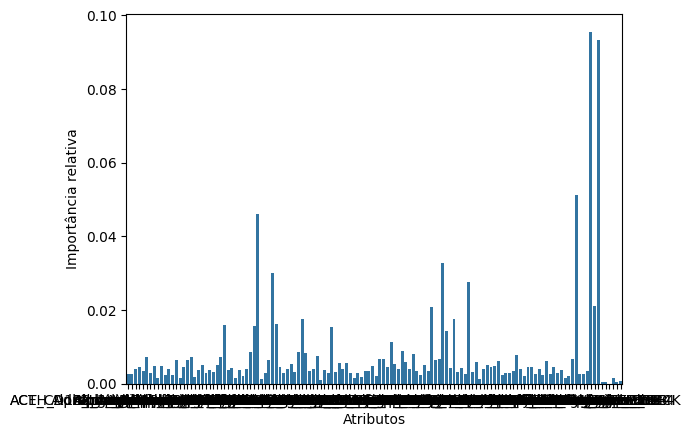

In [15]:
importancia = modelo.feature_importances_
features = features_treino.columns

eixo = sns.barplot(x=features, y=importancia)
eixo.set_ylabel("Importância relativa");
eixo.set_xlabel("Atributos");

Essa informação está aqui apresentada por ser uma função útil na melhor compreensão do modelo Random Forest.

Abaixo segue o *heatmap* com dados acerca das observações de teste e previsões atribuídas para cada observação.

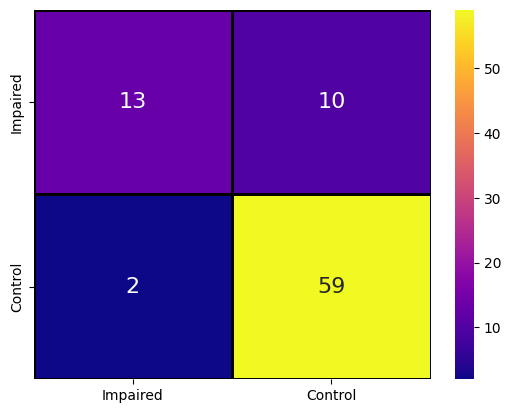

In [16]:
#Obtenção dos labels
labels = y_verdadeiro["Class"].unique().tolist()

#Obtenção da matrix de confusão
matriz_conf = confusion_matrix(y_verdadeiro, y_previsto, labels=labels)
df_conf = pd.DataFrame(matriz_conf, labels, labels)

#Plotagem do gráfico
sns.heatmap(df_conf, cmap=cm.plasma, annot=True, annot_kws={"size": 16}, linewidths=1, linecolor='black');

## Resultados

Para essa divisão de dados e seleção de hiperparâmetros, o modelo `RandomForestClassifier` apresentou um melhor desempenho em identificar as observações que pertencem à classe controle que aqueles pertencentes ao que queremos detectar. Isso de refletiu na métrica f1-score computada de $0.68$, embora a acurácia tenha atingido $0.86$.

## Referências

[1] Decision Tree, *Wikipedia*. Disponível em: https://en.wikipedia.org/wiki/Decision_tree

[2] Decision Trees, User Guide, *Scikit-learn*. Disponível em: https://scikit-learn.org/stable/modules/tree.html

[3] RandomForestClassifier, API Reference, *Scikit-learn*. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

[4] Material de aula da disciplina de aprendizado de máquina do professor doutor Cassar, D. R. disponibilizada no segundo semestre do curso de Bacharelado em Ciência e Tecnologia da Ilum - Escola de Ciência.